# Homework \#6
Name: Jonas Schweisthal \
Student number: s4535561

In [1]:
# New code since last assignment is framed in:
# NEW Start ----------------------------------------------------------

# NEW End ------------------------------------------------------------

In [2]:
from model import Model
from dmchunk import Chunk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

In [3]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

In [4]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

In [5]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

In [6]:
# Perform Experiments: 
def ready_set_go(n_participants, experiment):
    '''
         Simulates experiments 1 or 2 of Acerbi et al. (2012)

                Parameters:
                        a (int): number of participants conducting the experiment
                        b (int[1 or 2]): number defining the selected experiemnt

                Returns:
                        df (pandas.DataFrame): DataFrame containing the results of the experiment
    '''
    # number of subjects
    subjects = range(1,n_participants+1)
    if experiment == 1:
        # short, long
        conditions = ["Short Uniform", "Long Uniform"] 
    elif experiment == 2:
         # medium uniform, medium peaked
        conditions = ["Medium Uniform", "Medium Peaked"]
    # defining dataframe
# NEW Start ---------------------------------------------------------------------------------------
    # adding Priori to df
    df = pd.DataFrame(columns = ["Line", "Subj", "Cond", "Session", "Run", "Trial", "Ts", "Tp", "Main", "PriorProbs"])
# NEW End ---------------------------------------------------------------------------------------
    main = False
    line = 0
    for subj in subjects:
        # shuffling order of conditions randomly per subject
        np.random.shuffle(conditions)
        # own condition and model per subject as there is probably a long time between the two conditions
        for cond in conditions:
            m = Model()
            session = 1
            # set up for stopping if fractional change in mean squared timing error between sessions less than 0.08
            change_error = 1
            while change_error >= 0.08: 
                
                # between 5 and 6 runs per session a ~500 trials
                for run in np.arange(1, np.random.choice([5, 6])+1):
                    # between 84 and 96 trials per run
                    for trial in np.arange(1, np.random.randint(84, 97)):
                        
                        line += 1
                        # educated guess of about 2 seconds preparation time between trials
                        m.time += 2 
# NEW Start ---------------------------------------------------------------------------------------
                      
                        # calculating priors for the stored integer pulses before each trial
                        select = [chunk.name.startswith('pf') for chunk in m.dm]
                        chunks = np.array(m.dm)[select]
                        partial_pattern = Chunk(name = "prob-test", slots = {"isa" : "pulses-fact"})
                        priors = {chunk.name: m.get_retrieval_probability(chunk, partial_pattern ) for chunk in chunks}

# NEW End -----------------------------------------------------------------------------------------                              
                        
                        # draw out of 6 discrete values of discrete uniform distribution per condition
                        if cond == "Short Uniform":
                            ts = np.random.choice(np.linspace(0.45, 0.825, 6)).round(3) # rounding just for computational rounding errors necessary
                        elif cond == "Long Uniform":
                            ts = np.random.choice(np.linspace(0.75, 1.125, 6)).round(3)
                        elif cond == "Medium Uniform":
                            ts = np.random.choice(np.linspace(0.600, 0.975, 6)).round(3)
                        elif cond == "Medium Peaked":
                            ts = np.random.choice(np.linspace(0.600, 0.975, 6), 
                                                 p = [1/12, 7/12, 1/12, 1/12, 1/12, 1/12]).round(3)
                        m.time += ts

                        # time to pulses 
                        pulses = time_to_pulses(ts)
                        fact = Chunk(name = "pf" + str(pulses), slots ={"isa":"pulses-fact", "pulses": pulses})
                        # adding encounter of the perceived interval as pulses at the end time point of the presented interval
                        m.add_encounter(fact)
                        # flash time of 0.0185 seconds 
                        m.time += 0.0185
                        # adding time of 250 ms for minimum waiting after flash 
                        # 5ms time for storing encounter included here (simultaneously)
                        m.time += 0.250
                        
                        # retrieving blended trace
                        request = Chunk(name = "retrieve", slots = {"isa": "pulses-fact"})
                        pulses_retrieved, latency = m.retrieve_blended_trace(request, "pulses")
                        # m.time += latency is NOT added as discussed in supervision session
                        # converting blended trace of retrieved pulses to seconds
                        tp = pulses_to_time(pulses_retrieved)
                        # adding prodcution error for motoric mouseclicking of retrieved intervall possible
                        # here no error is added because
                        # adding production time
                        m.time += tp
                        
                        # random delay continuos random uniform distribution till feedback
                        delay = np.random.uniform(0.45, 0.85)
                        m.time += delay
                        # adding time of feedback
                        m.time += 0.062
                        # adding time fixation cross disappearing
                        m.time += np.random.uniform(0.5, 0.75)
                        # adding time for blank screen 
                        m.time += np.random.uniform(0.5, 0.75)
                        # new fixation cross signalling start of new trial
# NEW Start ---------------------------------------------------------------------------------------   
                        # adding prior to df
                        # store times in milliseconds in dataframe
                        df.loc[line-1] = [line, subj, cond, session, run, trial, ts*1000, tp*1000, main, priors]
# NEW End ---------------------------------------------------------------------------------------
                    # Subjects could take short breaks between runs, educated guess with 1 minute assumed to be realistic
                    m.time += 60                        
                        
                #checking if fractional change in mean squared timing error between sessions less than 0.08
                if change_error >= 0.08 and session >1:
                    change_error = abs(1-(((df[df.Session == session]["Tp"]-df[df.Session == session]["Ts"])**2).mean()/
                                    ((df[df.Session == session-1]["Tp"]-df[df.Session == session-1]["Ts"])**2).mean()))
                session += 1
            # set last two sessions per subject and block as Test (main = True)  
            df.loc[(df.Subj == subj) & (df.Cond == cond), 'Main'] = np.where(df.loc[(df.Subj == subj) & (df.Cond == cond), 'Session'] >
                                                                             df.loc[(df.Subj == subj) & (df.Cond == cond), 'Session'].max()-2,
                                                                            True, False)


    return df

In [7]:
# Simulating experiments 1 and 2 with 4 and 6 participants as mentioned in the paper
df_1 = ready_set_go(n_participants=4, experiment=1)
df_2 = ready_set_go(n_participants=6, experiment=2)

# changing Subject numbers for second experiment
df_2['Subj'] = df_2['Subj']+ df_1['Subj'].max() 

# combining datasets and calculating Bias
df = df_1.append(df_2, ignore_index = True)
df["Bias"] = df["Tp"] - df["Ts"]

In [8]:
# NEW Start ------------------------------------------------------------  

# Selecting just the Test sessions (Main==True) for the priors
# priors of all individual per condition
dfs_priors = {}
for cond in df.Cond.unique():
    df_cond = df[(df.Cond == cond) & (df.Main == True)]
    df_cond_prior = pd.DataFrame(df_cond['PriorProbs'].tolist()).reset_index()
    dfs_priors[cond] = pd.wide_to_long(df_cond_prior, stubnames='pf', i = 'index' , j = 'prior').reset_index().drop('index', axis = 1)
    dfs_priors[cond]['cond'] = cond
    
# priors of one individual per condition   
dfs_priors_individual = {}
for cond in df.Cond.unique():
    random_subj = np.random.choice(df[(df.Cond == cond)].Subj.unique())
    df_cond = df[(df.Cond == cond) & (df.Main == True) & (df.Subj == random_subj)]
    df_cond_prior = pd.DataFrame(df_cond['PriorProbs'].tolist()).reset_index()
    dfs_priors_individual[cond] = pd.wide_to_long(df_cond_prior, stubnames='pf', i = 'index' , j = 'prior').reset_index().drop('index', axis = 1)
    dfs_priors_individual[cond]['cond'] = cond
    
# concatenating the DataFrames
df_priors = pd.concat(dfs_priors.values())
df_priors_individual =  pd.concat(dfs_priors_individual.values())

# NEW End ------------------------------------------------------------  

In [9]:
# NEW Start ------------------------------------------------------------  

# Function pulses to time without any noise
def pulses_to_time_nonoise(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration
    return time

# NEW End --------------------------------------------------------------

In [10]:
# NEW Start ------------------------------------------------------------ 

# adding converting pulses to time without any noise as a column
# actually, "true" assumed prior exists for the stored integer pulses
# but for better comparison with acerbi plots integer pulses transformed to ms without noise is used
# as noise wouldn't make any sense since there's not happening any real converting
df_priors['ms'] = df_priors.prior.apply(lambda x: pulses_to_time_nonoise(x)*1000)
df_priors_individual['ms'] = df_priors_individual.prior.apply(lambda x: pulses_to_time_nonoise(x)*1000)

# NEW End --------------------------------------------------------------

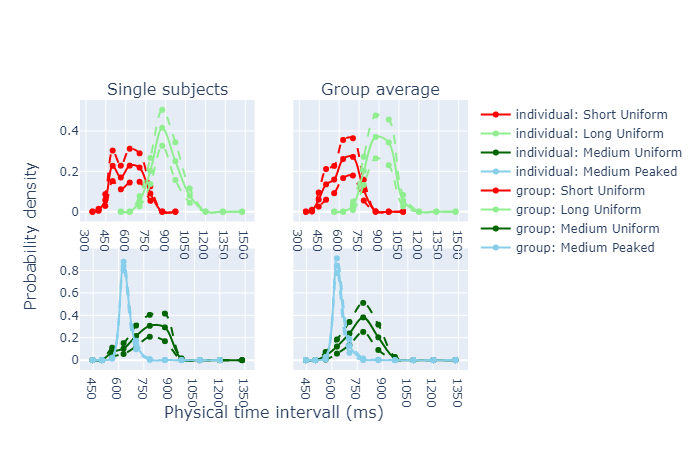

In [12]:
# NEW End ------------------------------------------------------------  

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=2, shared_xaxes = False, shared_yaxes = True, 
                    subplot_titles=("Single subjects", "Group average", None, None),
                   y_title='Probability density',
                    x_title='Physical time intervall (ms)',
                    vertical_spacing=0.1)
cols = {'Short Uniform': 'red', 'Long Uniform': 'lightgreen', 'Medium Uniform': 'darkgreen', 'Medium Peaked': 'skyblue'}
# plotting individual and group priors
for df_plot, plot in zip([df_priors_individual, df_priors], ['individual', 'group']):
    if plot == 'individual':
        move_position = -1
    else: 
        move_position = 0
    for cond, pos in zip(['Short Uniform', 'Long Uniform', 'Medium Uniform', 'Medium Peaked'],
                         [[1, 2], [1, 2], [2, 2], [2, 2]]):
    #    print(cond + str(pos))

        points = df_plot[df_plot.cond == cond]
        means = df_plot[df_plot.cond == cond].groupby('prior').mean()
        sds = df_plot[df_plot.cond == cond].groupby('prior').std()
        sd_upper = means + sds
        sd_lower = means - sds



        fig.add_trace(go.Scatter(x = means.ms,
                                 y= means.pf, name=plot + ': ' +cond,
                            line_shape='spline',
                                line=dict(color=cols[cond])), row=pos[0], col=pos[1]+move_position)
        fig.add_trace(go.Scatter(x = sd_upper.ms,
                                 y= sd_upper.pf, showlegend=False,
                            line_shape='spline', 
                            line=dict(color=cols[cond], width=2, dash='dash')
                                ), row=pos[0], col=pos[1]+move_position)
        fig.add_trace(go.Scatter(x = sd_lower.ms,
                                 y= sd_lower.pf, showlegend=False,
                            line_shape='spline',
                            line=dict(color=cols[cond], width=2, dash='dash')
                                ), row=pos[0], col=pos[1]+move_position)

fig.update_layout(
    xaxis1 = dict(
        tickmode = 'linear',
        tick0 = 300,
        dtick = 150),
    xaxis2 = dict(
        tickmode = 'linear',
        tick0 = 300,
        dtick = 150),
    xaxis3 = dict(
        tickmode = 'linear',
        tick0 = 450,
        dtick = 150),
    xaxis4 = dict(
        tickmode = 'linear',
        tick0 = 450,
        dtick = 150),
    yaxis1 = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.2),
    yaxis2 = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.2),
    yaxis3 = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.2),
    yaxis4 = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.2)
)

fig.update_layout(width = 950, height = 500)
# show as png (recognizable for pdf but no nice layout)
fig.show('png' )

# showing as interactive Plotly Graph (nicer, but not displayed in Notebook without code execution)
fig.show()

fig.write_image('plot7.png')

# NEW End ------------------------------------------------------------  